# smallNORB Model and Training

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

from tqdm import tqdm
from pytorch_extras import RAdam, SingleCycleScheduler
from deps.small_norb.smallnorb.dataset import SmallNORBDataset
from deps.torch_train_test_loop.torch_train_test_loop import LoopComponent, TrainTestLoop

from heinsen_routing import Routing

In [2]:
DEVICE = 'cuda:0'

## Define model

In [3]:
class Swish(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * x.sigmoid()


class SmallNORBClassifier(nn.Module):

    def __init__(self, n_objs, n_parts, d_chns):
        super().__init__()
        self.convolve = nn.Sequential(
            nn.BatchNorm2d(2 + 2), nn.Conv2d(2 + 2, d_chns, kernel_size=3), Swish(),
            nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, d_chns, kernel_size=3, stride=2), Swish(),
            nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, d_chns, kernel_size=3), Swish(),
            nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, d_chns, kernel_size=3, stride=2), Swish(),
            nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, d_chns, kernel_size=3), Swish(),
            nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, d_chns, kernel_size=3, stride=2), Swish(),
        )
        self.compute_a = nn.Sequential(nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, n_parts, 1))
        self.compute_mu = nn.Sequential(nn.BatchNorm2d(d_chns), nn.Conv2d(d_chns, n_parts * 4 * 4, 1))
        self.routings = nn.Sequential(
            Routing(d_spc=4, d_out=4, n_out=n_parts, d_inp=4, n_iters=3),
            Routing(d_spc=4, d_out=4, n_out=n_objs, d_inp=4, n_inp=n_parts, n_iters=3),
        )

    def add_coord_grid(self, x):
        h, w = x.shape[-2:]
        coord_grid = torch.stack((
            torch.linspace(-1.0, 1.0, steps=h, device=x.device)[:, None].expand(-1, w),
            torch.linspace(-1.0, 1.0, steps=w, device=x.device)[None, :].expand(h, -1),
        )).expand([*x.shape[:-3], -1, -1, -1])
        return torch.cat((x, coord_grid), dim=-3)
        
    def forward(self, images):
        x = self.add_coord_grid(images)                        # [bs, (2 + 2), h, w]
        x = self.convolve(x)                                   # [bs, d_chns, h', w']

        a = self.compute_a(x)                                  # [bs, n_parts, h', w']
        a = a.view(a.shape[0], -1)                             # [bs, (n_parts * h' * w')]

        mu = self.compute_mu(x)                                # [bs, (n_parts * 4 * 4), h', w']
        mu = mu.view([mu.shape[0], -1, 4, 4, *mu.shape[-2:]])  # [bs, n_parts, 4, 4, h', w']
        mu = mu.permute(0, 1, 4, 5, 2, 3).contiguous()         # [bs, n_parts, h', w', 4, 4]
        mu = mu.view(mu.shape[0], -1, 4, 4)                    # [bs, (n_parts * h' * w'), 4, 4]

        for route in self.routings:
            a, mu, _ = route(a, mu)

        return a                                               # [bs, n_objs]

## Prepare datasets

In [4]:
smallnorb = SmallNORBDataset(dataset_root='.data/smallnorb')

Loading info...: 100%|██████████| 24300/24300 [00:00<00:00, 251543.34it/s]


In [44]:
set([s.instance for s in smallnorb.data['test']])

{0, 1, 2, 3, 5}

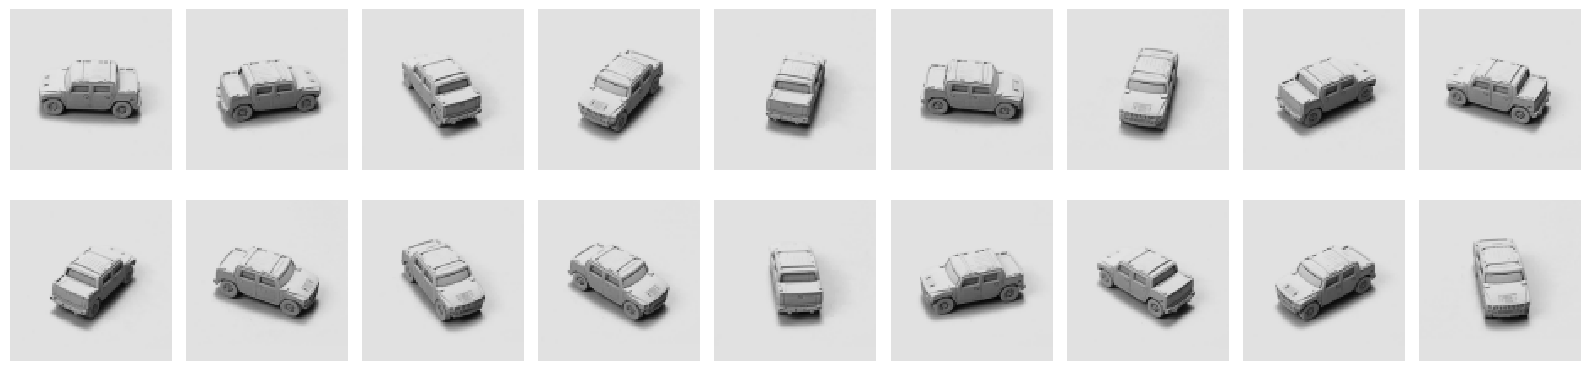

In [160]:
samples = [
    s for s in smallnorb.data['train'] 
    if (s.category, s.instance, s.lighting, s.elevation) == (3, 9, 0, 0)
]
fig, axes = plt.subplots(ncols=9, nrows=2, figsize=(16, 4.3))
for axis1, sample in zip(axes.flatten(), samples):
    axis1.imshow(sample.image_lt, cmap='gray', vmin=0, vmax=255)
    axis1.axis('off')

fig.tight_layout()

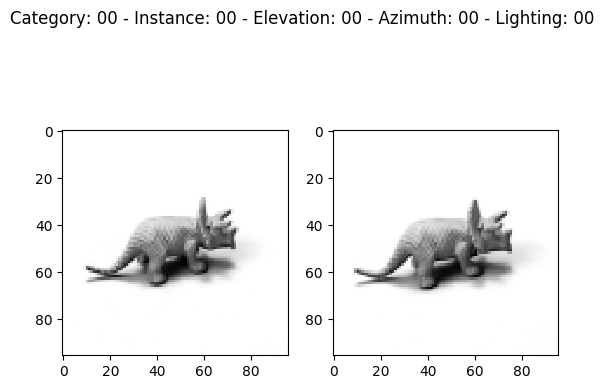

In [61]:
samples[0].show(plt.subplots(ncols=2))

In [ ]:
class SmallNORBTorchDataset(torch.utils.data.Dataset):

    def __init__(self, data, categories, preprocessing):
        self.data = data
        self.categories = categories
        self.preprocess = preprocessing

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        images = np.stack((self.data[i].image_lt, self.data[i].image_rt), axis=-1)  # [96, 96, 2]
        images = self.preprocess(images).cuda(device=DEVICE)  # [2, 96, 96]
        category = torch.tensor(self.data[i].category, dtype=torch.long).cuda(device=DEVICE)
        return { 'images': images, 'category': category, }

random_crops = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.RandomCrop(size=96, padding=16, padding_mode='edge'),
    tv.transforms.ToTensor()
])

# Normally we would divide train set into train/valid splits; we don't here to match other papers.
trn_ds = SmallNORBTorchDataset(smallnorb.data['train'], smallnorb.categories, random_crops)
val_ds = SmallNORBTorchDataset(smallnorb.data['test'], smallnorb.categories, random_crops)
tst_ds = SmallNORBTorchDataset(smallnorb.data['test'], smallnorb.categories, tv.transforms.ToTensor())

## Training Loop

In [ ]:
class LoopMain(LoopComponent):

    def __init__(self, n_classes, device, pct_warmup=0.1, mixup=(0.2, 0.2)):
        self.n_classes, self.device, self.pct_warmup = (n_classes, device, pct_warmup)
        self.mixup_dist = torch.distributions.Beta(torch.tensor(mixup[0]), torch.tensor(mixup[1]))
        self.to_onehot = torch.eye(self.n_classes, device=self.device)

    def on_train_begin(self, loop):
        n_iters = len(loop.train_data) * loop.n_epochs
        loop.optimizer = RAdam(loop.model.parameters(), lr=5e-4)
        loop.scheduler = SingleCycleScheduler(loop.optimizer, loop.n_optim_steps, frac=self.pct_warmup, min_lr=1e-5)

    def on_grads_reset(self, loop):
        loop.model.zero_grad()

    def on_forward_pass(self, loop):
        images, category = loop.batch['images'], loop.batch['category']
        target_probs = self.to_onehot[category]

        if loop.is_training:
            r = self.mixup_dist.sample([len(images)]).to(device=images.device)
            idx = torch.randperm(len(images))
            images = images.lerp(images[idx], r[:, None, None, None])
            target_probs = target_probs.lerp(target_probs[idx], r[:, None])

        pred_scores = model(images)
        _, pred_ids = pred_scores.max(-1)
        accuracy = (pred_ids == category).float().mean()

        loop.pred_scores, loop.target_probs, loop.accuracy = (pred_scores, target_probs, accuracy)

    def on_loss_compute(self, loop):
        losses = -loop.target_probs * F.log_softmax(loop.pred_scores, dim=-1)  # smooth cross entropy
        loop.loss = losses.sum(dim=-1).mean()  # sum across classes, then mean of batch

    def on_backward_pass(self, loop):
        loop.loss.backward()

    def on_optim_step(self, loop):
        loop.optimizer.step()
        loop.scheduler.step()

In [ ]:
class LoopProgressBar(LoopComponent):

    def __init__(self, item_names=['loss', 'accuracy']):
        self.item_names = item_names

    def on_epoch_begin(self, loop):
        self.total, self.count = ({ name: 0.0 for name in self.item_names }, 0)
        self.pbar = tqdm(total=loop.n_batches, desc=f"{loop.epoch_desc} epoch {loop.epoch_num}")

    def on_batch_end(self, loop):
        n = len(loop.batch['images'])
        self.count += n
        for name in self.item_names:
            self.total[name] += getattr(loop, name).item() * n
        self.pbar.update(1)
        if (not loop.is_training):
            self.pbar.set_postfix(self.mean)

    def on_epoch_end(self, loop):
        self.pbar.close()

    @property
    def mean(self): return { f'mean_{name}': self.total[name] / self.count for name in self.item_names }

## Initialize and train model

In [ ]:
# Seed RNG for replicability.
torch.manual_seed(1)

# Make iterators for each split, with random shuffling in train set.
trn_itr = torch.utils.data.DataLoader(trn_ds, batch_size=20, shuffle=True)
val_itr = torch.utils.data.DataLoader(val_ds, batch_size=20, shuffle=False)
tst_itr = torch.utils.data.DataLoader(tst_ds, batch_size=20, shuffle=False)

# Initialize model.
n_classes = len(trn_ds.categories)
model = SmallNORBClassifier(n_objs=n_classes, n_parts=64, d_chns=64)
model = model.cuda(device=DEVICE)

# Train model
loop = TrainTestLoop(model, [LoopMain(n_classes, DEVICE), LoopProgressBar()], trn_itr, val_itr)
loop.train(n_epochs=50)

## Test model

In [ ]:
loop.test(tst_itr)